In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import make_pipeline as imb_make_pipeline
from imblearn.over_sampling import RandomOverSampler

from scikitplot.metrics import plot_ks_statistic, plot_roc

In [3]:
%matplotlib inline
%load_ext watermark
%watermark -iv -psklearn,scikitplot

matplotlib 3.0.2
seaborn    0.9.0
numpy      1.15.4
pandas     0.24.0
sklearn 0.20.2
scikitplot 0.3.7


In [4]:
df = pd.read_pickle('../data/churn_cleaned.pkl')

# Make cohorts  
Churn is generally done as a cohort analysis -- customers who entered at the same time have experienced similar
ads, prices, and other exogenous events not recorded in the database. It tends to do a better job comparing apples to apples.

I know from EDA that the churn is not divided evenly by customer tenure, but I also don't want to make my
sample sizes too small. 

If I were a real cable company, there'd be plenty of data. But, I've only got 7000 rows from Kaggle. So, I'm
only going to make four cohorts. By dividing them by quartiles, I get even-sized cohorts at the expense of having
uniform bands of time per cohort.

My cohorts are 0 to 9 months, then 10 to 29, 30 to 55, and 56 to 72 months.

In [5]:
n_cohorts = 4 
tenure_c, bins = pd.qcut(df.tenure, n_cohorts, labels=range(n_cohorts), retbins=True)

In [6]:
tenure_c.value_counts()

0    1854
3    1755
2    1719
1    1715
Name: tenure, dtype: int64

In [7]:
bins

array([ 0.,  9., 29., 55., 72.])

In [8]:
pd.Series(bins).diff()

0     NaN
1     9.0
2    20.0
3    26.0
4    17.0
dtype: float64

In [9]:
df['tenure_c'] = tenure_c

In [10]:
cohort_table = pd.DataFrame(index=range(n_cohorts), columns=['min_tenure','max_tenure', 'name'])
g = df.groupby('tenure_c')
for i in range(n_cohorts):
    group = g.get_group(i)
    cohort_table.loc[i,'min_tenure'] = group['tenure'].min()
    cohort_table.loc[i,'max_tenure'] = group['tenure'].max()
cohort_table.name = cohort_table.min_tenure.astype(str) + " - " + cohort_table.max_tenure.astype(str) + " months"

In [11]:
cohorts = [ df.query(f"tenure_c == {i}") for i in range(n_cohorts) ]

In [12]:
for i,cohort in enumerate(cohorts):
    counts = cohort.Churn.value_counts()
    
    cohort_table.loc[i,'observations'] = cohort.shape[0]
    cohort_table.loc[i, 'churn_yes'] = counts['Yes']
    cohort_table.loc[i, 'churn_no'] = counts['No']

cohort_table['churn_pct'] = cohort_table['churn_yes'] / cohort_table['observations']
cohort_table

,min_tenure,max_tenure,name,observations,churn_yes,churn_no,churn_pct
0,0,9,0 - 9 months,1854.0,923.0,931.0,0.497843
1,10,29,10 - 29 months,1715.0,486.0,1229.0,0.283382
2,30,55,30 - 55 months,1719.0,324.0,1395.0,0.188482
3,56,72,56 - 72 months,1755.0,136.0,1619.0,0.077493


# Preprocessing

To preprocess, I'm one-hot encoding the categorical variables and using StandardScaler for the 
numerical features. 

For logistic regression, I don't want collinear features. I'm dropping "No internet service" everywhere
for that reason. i.e. "OnlineBackup_No internet service" and "DeviceProtection_No internet service" should
be exactly the same one-hot vector.

In [13]:
def preprocess_cohort(cohort):
    y = cohort.Churn.map(dict(Yes=1,No=0))
    X = cohort.drop(columns=['customerID','Churn','tenure_c'])
    
    cols = X.columns
    numerical = [ 'tenure', 'MonthlyCharges', 'TotalCharges']
    categorical = [ c for c in cols if c not in numerical ]
    
    X = pd.concat([X[numerical], pd.get_dummies(X[categorical])], axis=1)
    
    # need to drop one-hot variables with an eye towards preventing collinearity
    collinear_cats = [c for c in X.columns if c.find("_No") != -1 ]
    X = X.drop(columns=collinear_cats)
    X = X.drop(columns=['gender_Female', 'SeniorCitizen_0', "Contract_Two year",
                       "PaymentMethod_Mailed check"])
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y)
    
    X_train = X_train.copy()
    X_test = X_test.copy()
    
    ss = StandardScaler()
    ss.fit(X_train[numerical].astype(np.float))
    X_train[numerical] = ss.transform(X_train[numerical].astype(np.float))
    X_test[numerical] = ss.transform(X_test[numerical].astype(np.float))
    
    return X_train, X_test, y_train, y_test

# Utitility function to stash model results

This way I can compare my models side-by-side rather than one at a time

In [14]:
def save_result(clf, X_train, y_train, X_test, y_test):
    clf = clf.best_estimator_.steps[1][1]
    yhat = clf.predict(X_test)
    yproba = clf.predict_proba(X_test)
    return dict(
        cm=confusion_matrix(y_test, yhat),
        y=y_test,
        yhat=yhat,
        yproba=yproba,
        report=classification_report(y_test,yhat),
        train_score=clf.score(X_train, y_train),
        test_score=clf.score(X_test,y_test),
        clf=clf,
        cols=X_test.columns,
        xtest=X_test
    )

# Logistic Regression

In [15]:
scores = [0] * n_cohorts

for i,cohort in enumerate(cohorts):
    X_train, X_test, y_train, y_test = preprocess_cohort( cohort)
    
    pipe = imb_make_pipeline(
        RandomOverSampler(random_state=42),
        LogisticRegression(max_iter=200, solver='lbfgs')
    )
    
    clf = GridSearchCV(
        pipe,
        dict(
            logisticregression__C=np.logspace(-4,4,20)
        ),
        iid = False,
        n_jobs = -1,
        cv = 4,
        verbose = True
    )
    
    clf.fit(X_train, y_train)
    
    scores[i] = save_result(clf, X_train, y_train, X_test, y_test)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  65 out of  80 | elapsed:    3.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 20 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.7s finished



# Random Forest

In [21]:
treescores = [0] * n_cohorts

for i,cohort in enumerate(cohorts):
    X_train, X_test, y_train, y_test = preprocess_cohort( cohort)
    
    pipe = imb_make_pipeline(
        RandomOverSampler(random_state=42),
        RandomForestClassifier()
    )
    
    clf = GridSearchCV(
        pipe,
        dict( 
            randomforestclassifier__n_estimators=[25],
            randomforestclassifier__max_depth=[3,4,5], 
            randomforestclassifier__min_samples_leaf=[5,10],
            randomforestclassifier__max_features=[3,4,5]
        ),
        iid = False,
        n_jobs = -1,
        cv = 4,
        verbose = True
    )
    
    clf.fit(X_train, y_train)
    
    treescores[i] = save_result(clf, X_train, y_train, X_test, y_test)

Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:    0.9s finished


# Results

In [22]:
def plot_stuff( lr_result, tree_result):
    
    fig,axs = plt.subplots(1,2,sharey=True, figsize=(10,4))
    fig.suptitle('ROC curves')
    plot_roc( lr_result['y'], lr_result['yproba'], title="Logistic Regression",
             plot_micro=False, plot_macro=False, classes_to_plot=[0,1], ax=axs[0] ) 
    plot_roc( tree_result['y'], tree_result['yproba'], title="Random Forest",
             plot_micro=False, plot_macro=False, classes_to_plot=[0,1], ax=axs[1] ) 
    plt.show()
    
    fig,axs = plt.subplots(1,2,sharey=True, figsize=(10,4))
    fig.suptitle('K-S Statistic')
    plot_ks_statistic( lr_result['y'], lr_result['yproba'], title="Logistic Regression",
                          ax=axs[0] ) 
    plot_ks_statistic( tree_result['y'], tree_result['yproba'], title="Random Forest",
                          ax=axs[1] ) 
    plt.show()
    
def print_stuff( lr_result, tree_result, title ):
    print(title)
    print("Logistic Regression")
    print("\tTrain, test accuracy ", lr_result['train_score'], lr_result['test_score'])
    print("Confusion Matrix")
    print(lr_result['cm'])
    print(lr_result['report'])
    
    print("Random Forest")
    print("\tTrain, test accuracy ", tree_result['train_score'], tree_result['test_score'])
    print("Confusion Matrix")
    print(tree_result['cm'])
    print(tree_result['report'])

===== Cohort 0 : 0 - 9 months ====== 
Logistic Regression
	Train, test accuracy  0.7273381294964029 0.6831896551724138
Confusion Matrix
[[156  77]
 [ 70 161]]
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       233
           1       0.68      0.70      0.69       231

   micro avg       0.68      0.68      0.68       464
   macro avg       0.68      0.68      0.68       464
weighted avg       0.68      0.68      0.68       464

Random Forest
	Train, test accuracy  0.7172661870503597 0.7262931034482759
Confusion Matrix
[[168  65]
 [ 62 169]]
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       233
           1       0.72      0.73      0.73       231

   micro avg       0.73      0.73      0.73       464
   macro avg       0.73      0.73      0.73       464
weighted avg       0.73      0.73      0.73       464



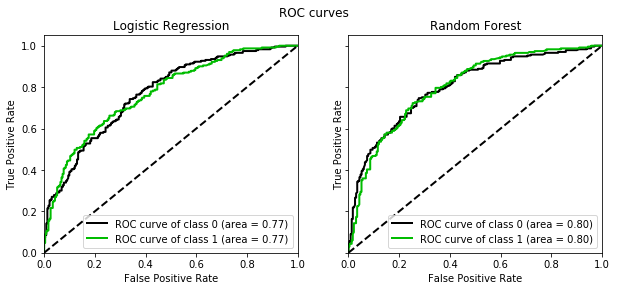

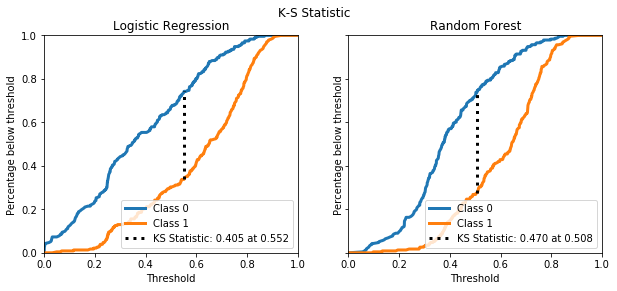

===== Cohort 1 : 10 - 29 months ====== 
Logistic Regression
	Train, test accuracy  0.7317262830482115 0.7389277389277389
Confusion Matrix
[[223  84]
 [ 28  94]]
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       307
           1       0.53      0.77      0.63       122

   micro avg       0.74      0.74      0.74       429
   macro avg       0.71      0.75      0.71       429
weighted avg       0.79      0.74      0.75       429

Random Forest
	Train, test accuracy  0.7620528771384136 0.7389277389277389
Confusion Matrix
[[223  84]
 [ 28  94]]
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       307
           1       0.53      0.77      0.63       122

   micro avg       0.74      0.74      0.74       429
   macro avg       0.71      0.75      0.71       429
weighted avg       0.79      0.74      0.75       429



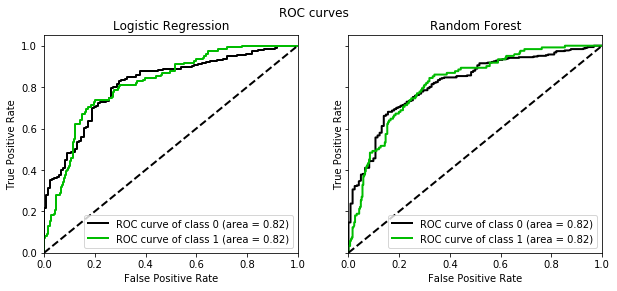

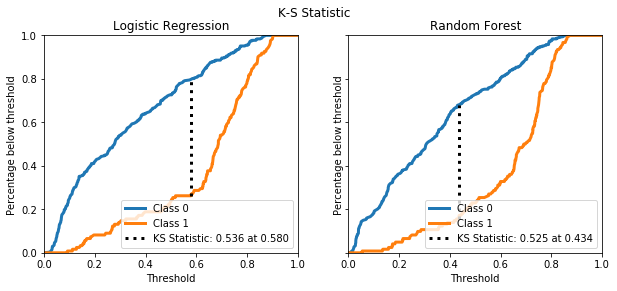

===== Cohort 2 : 30 - 55 months ====== 
Logistic Regression
	Train, test accuracy  0.7051978277734678 0.6674418604651163
Confusion Matrix
[[227 122]
 [ 21  60]]
              precision    recall  f1-score   support

           0       0.92      0.65      0.76       349
           1       0.33      0.74      0.46        81

   micro avg       0.67      0.67      0.67       430
   macro avg       0.62      0.70      0.61       430
weighted avg       0.81      0.67      0.70       430

Random Forest
	Train, test accuracy  0.7176105508145849 0.6930232558139535
Confusion Matrix
[[237 112]
 [ 20  61]]
              precision    recall  f1-score   support

           0       0.92      0.68      0.78       349
           1       0.35      0.75      0.48        81

   micro avg       0.69      0.69      0.69       430
   macro avg       0.64      0.72      0.63       430
weighted avg       0.81      0.69      0.73       430



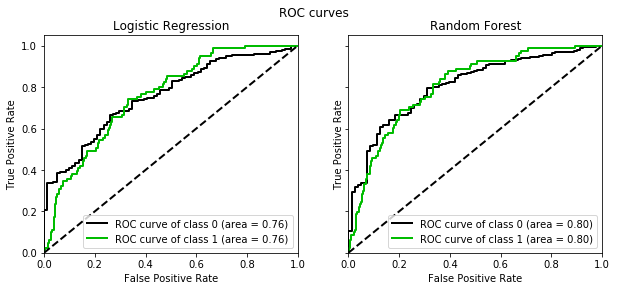

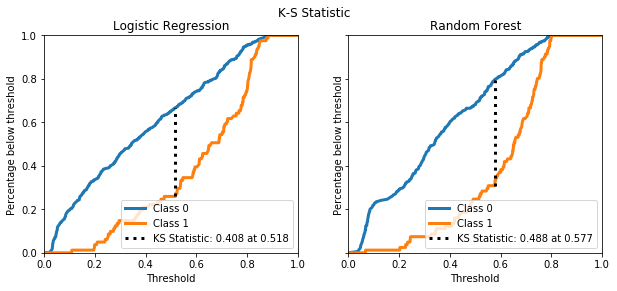

===== Cohort 3 : 56 - 72 months ====== 
Logistic Regression
	Train, test accuracy  0.7386018237082067 0.7517084282460137
Confusion Matrix
[[304 101]
 [  8  26]]
              precision    recall  f1-score   support

           0       0.97      0.75      0.85       405
           1       0.20      0.76      0.32        34

   micro avg       0.75      0.75      0.75       439
   macro avg       0.59      0.76      0.59       439
weighted avg       0.91      0.75      0.81       439

Random Forest
	Train, test accuracy  0.7735562310030395 0.7494305239179955
Confusion Matrix
[[315  90]
 [ 20  14]]
              precision    recall  f1-score   support

           0       0.94      0.78      0.85       405
           1       0.13      0.41      0.20        34

   micro avg       0.75      0.75      0.75       439
   macro avg       0.54      0.59      0.53       439
weighted avg       0.88      0.75      0.80       439



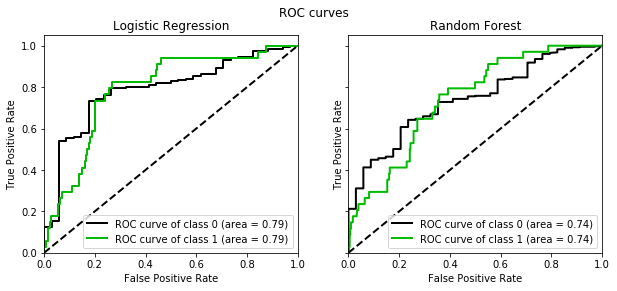

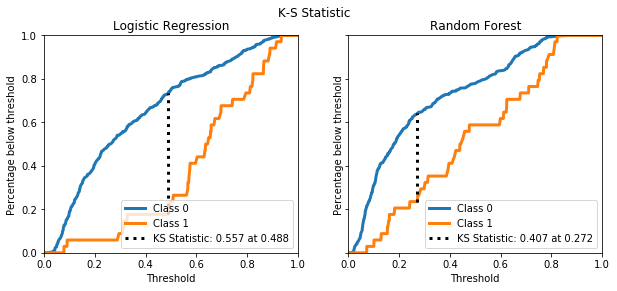

In [23]:
for i in range(n_cohorts):
    print_stuff(scores[i], treescores[i], f"===== Cohort {i} : {cohort_table.loc[i,'name']} ====== " )
    plot_stuff(scores[i], treescores[i])

# Feature coefficients (Logistic Regression)
Because Random Forest is throwing away features randomly under the covers, the default output for
feature_importance from sklearn is not reliable. For a short-term project, let's just look at the 
feature coefficients for the LR model.

In [19]:
for i in range(n_cohorts):
    print(f"===== Cohort {i} : {cohort_table.loc[i,'name']} ====== " )
    coeffs = pd.DataFrame(data=scores[i]['clf'].coef_, columns=scores[i]['cols'], index=['coef']).T
    coeffs['abs'] = coeffs.eval('abs(coef)')
    top5 = coeffs.sort_values('abs', ascending=False).head(5)[['coef']]
    print(top5)
    print("\n")

===== Cohort 0 : 0 - 9 months ====== 
                                 coef
Contract_Month-to-month      5.018264
Contract_One year            3.648445
PhoneService_Yes            -1.769631
MonthlyCharges               1.542244
InternetService_Fiber optic -1.221898


===== Cohort 1 : 10 - 29 months ====== 
                                    coef
PhoneService_Yes               -0.722657
Contract_Month-to-month         0.699321
MonthlyCharges                  0.654753
PaymentMethod_Electronic check  0.594668
InternetService_Fiber optic     0.561770


===== Cohort 2 : 30 - 55 months ====== 
                                 coef
Contract_Month-to-month      1.615997
PhoneService_Yes            -0.990342
InternetService_Fiber optic  0.728024
Contract_One year            0.676895
MonthlyCharges               0.389499


===== Cohort 3 : 56 - 72 months ====== 
                                    coef
PaymentMethod_Electronic check  0.810126
PhoneService_Yes               -0.697795
Contract_Mo

Cohort 0 is the only cohort where tenure comes in, with a negative coefficient. The the longer the amount of time the 
customer has stayed, the less likely they are to churn. This corresponds to the EDA observation that the 
highest churn is during the first month of service.

With one-hot encoding, a feature is always dropped to prevent collinearity. When the model is selecting on all the
values that weren't dropped, that feature is the one that's important, in the opposite direction. So, in cohort 1,
the positive coefficients for fiber optic and DSL implies that there would be a negative coefficient if InternetService = 'No internet service' was not dropped, which is compatible with the result in cohort 0 that having a phone line makes a
customer less likely to drop. 

# Conclusions
Useful models were created for each cohort, with about 70 percent overall accuracy. 

One thing I missed during EDA was that having a phone line makes a customer less likely to churn compared to 
internet/TV only customers.

In [20]:
corr_example = pd.get_dummies(df.InternetService)
corr_example = pd.concat([df.MonthlyCharges, corr_example['Fiber optic']], axis=1)
corr_example.corr()

,MonthlyCharges,Fiber optic
MonthlyCharges,1.000000,0.787066
Fiber optic,0.787066,1.000000


One thing I noticed while tuning the models was that monthly charges are higher for fiber optic customers.
During EDA, I treated 'monthly payment' and 'fiber optic' as separate features when in fact they are correlated.
Overall is 79% correlated, but this is higher in the earlier cohorts than the later ones because the high paying 
fiber optic customers are dropping out more quickly over time. 

The business needs to investigate and try to separate how cost and product satisfaction issues affect the choice to drop the fiber optic service.

# Future work

A more logical cohort analysis would be splitting cohorts by contract type (a major predictor of churn) or product(s)
purchased (phone, internet, both) and then by years, so something like: 

   -  Month to month: less than one year, 1 to 2 years, 2 to 3 years, etc.
   -  One year contract: less than one year, 1 to 2 years, 2 to 3 years, etc.
   -  Two year contract: less than one year, 1 to 2 years, 2 to 3 years, etc.
   
Due to the relatively small dataset, it didn't make sense to slice-and-dice the data into that many pieces. Hence, my
choice to just make four cohorts by tenure quantiles.

The feature importance analysis is only run on the Logisitc Regression : Need to do a proper test (such as a permutation
test or a model-based feature search) to extract the feature importance from the Random Forest model. 

Both models could probably use a little more hyperparameter tuning.